### Project 2 | Introduction to Neural Networks and Deep Learning

Street View House Number (SVHN)

#### Load the packages

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Reshape, BatchNormalization, Input
from keras.callbacks import ModelCheckpoint, EarlyStopping

import h5py

from warnings import filterwarnings
filterwarnings('ignore')

#### Mount the drive to read the dataset and execute the required linux cmds

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! ls -lh "/content/drive/My Drive/1.Dataset"

total 2.2G
drwx------ 2 root root 4.0K Jan 23 18:54 plant-seedlings-classification-CNN
-rw------- 1 root root 1.7G Jan 23 18:41 plant-seedlings-classification.zip
-rw------- 1 root root 469M Jan 26 09:21 SVHN_single_grey1.h5


#### Load the data-set

In [0]:
file_path = "/content/drive/My Drive/1.Dataset/SVHN_single_grey1.h5" 
fp = h5py.File(file_path)

In [5]:
list(fp)

['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']

In [0]:
X_train = fp['X_train']
y_train = fp['y_train']

X_val = fp['X_val']
y_val = fp['y_val']

X_test = fp['X_test']
y_test = fp['y_test']

In [7]:
type(X_train)

h5py._hl.dataset.Dataset

#### convert it from list to array

In [0]:
X_train = np.asarray(X_train,dtype=np.float32)
y_train = np.asarray(y_train)

X_val = np.asarray(X_val,dtype=np.float32)
y_val = np.asarray(y_val)

X_test = np.asarray(X_test,dtype=np.float32)
y_test = np.asarray(y_test)

#### Understand the data-set's shape, dimension and other details etc.

In [9]:
print('Shape for train data-set are{}{}'.format(X_train.shape, y_train.shape))
print('Shape for validation data-set are{}{}'.format(X_val.shape, y_val.shape))
print('Shape for test data-set are{}{}'.format(X_test.shape, y_test.shape))

Shape for train data-set are(42000, 32, 32)(42000,)
Shape for validation data-set are(60000, 32, 32)(60000,)
Shape for test data-set are(18000, 32, 32)(18000,)


In [10]:
print('train data-set dimensions are {}'.format(X_train.ndim))
print('train data-points size & shape are {} {}'.format(np.size(X_train[0]),X_train[0].shape))

train data-set dimensions are 3
train data-points size & shape are 1024 (32, 32)


In [11]:
y_train[0]

2

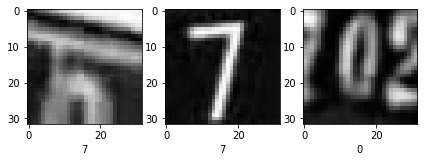

In [12]:
fig_ax = plt.figure(figsize=(7,9))

j=1
r_int = np.random.randint(1,X_train.shape[0], size=3)
for i in r_int:
  plt.subplot(1,3,j)
  plt.imshow(X_train[i], cmap=plt.cm.Greys )
  plt.xlabel(y_train[i])
  j+=1

plt.show()

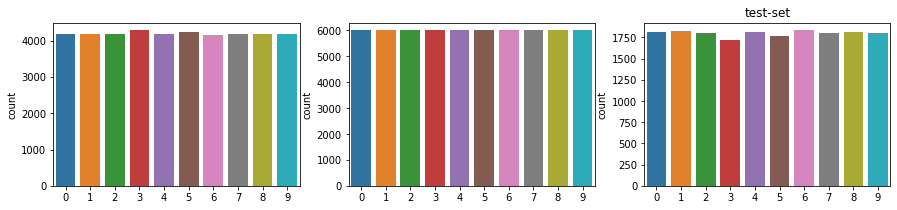

In [13]:
fig, ax= plt.subplots(1,3, figsize=(15,3))

def cntplt(xD, pltAxis, Label ):
  sns.countplot(x=xD, ax=pltAxis)
  plt.title(Label)

cntplt(y_train, ax[0], 'train-set')
cntplt(y_val, ax[1], 'val-set')
cntplt(y_test, ax[2], 'test-set')

plt.show()

#### For executing knn model , get the copy of original data-set 
Thought may not necessay, but as to avoid any issue later take copy and proceed 

In [0]:
Knn_x_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
knn_x_val = X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2]) 
knn_x_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

In [0]:
knn_y_train_label = y_train
knn_y_val_label = y_val
knn_y_test_label = y_test

In [16]:
X_train[0]

array([[ 33.0704,  30.2601,  26.852 , ...,  71.4471,  58.2204,  42.9939],
       [ 25.2283,  25.5533,  29.9765, ..., 113.0209, 103.3639,  84.2949],
       [ 26.2775,  22.6137,  40.4763, ..., 113.3028, 121.775 , 115.4228],
       ...,
       [ 28.5502,  36.212 ,  45.0801, ...,  24.1359,  25.0927,  26.0603],
       [ 38.4352,  26.4733,  23.2717, ...,  28.1094,  29.4683,  30.0661],
       [ 50.2984,  26.0773,  24.0389, ...,  49.6682,  50.853 ,  53.0377]],
      dtype=float32)

In [0]:
# X_train = X_train/255

#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
#X_val = X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2])
#X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

#sc = StandardScaler()

#X_std_train = sc.fit_transform(X_train)
#X_std_val = sc.transform(X_val)
#X_std_test = sc.transform(X_test)

In [18]:
y_train[0]

2

#### Convert label to catergorical for NN

In [0]:
y_train = tf.keras.utils.to_categorical(y_train,num_classes=10)
y_val = tf.keras.utils.to_categorical(y_val,num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test,num_classes=10)

In [20]:
y_train[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

#### GridsearcCV for understandign the better hyperparameters for the basic NN. 
From the learnt hyperparameters build then build the network

#### CV for better epochs 

In [0]:
def create_model(learn_rate=0.01, momentum=0):
  # create model
  model = Sequential() 
  
  # Reshape data 
  model.add( Reshape( (1024,), input_shape=(32,32) ) )
  
  # Normalize the data
  model.add(BatchNormalization())
  
  # Add hidden layers
  model.add(Dense(128, activation='relu'))
	
  # Output layers
  model.add(Dense(10, activation='softmax'))
	
  # Compile model
  #optimizer = keras.optimizers.SGD(lr=learn_rate, momentum=momentum)
  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
  return model

In [0]:
model = KerasClassifier(build_fn=create_model)

# define the grid search parameters
#learn_rate = [0.001, 0.01]
#momentum = [0.0, 0.2]
#param_grid = dict(learn_rate=learn_rate, momentum=momentum)

epochs = [30, 40, 50, 70]
param_grid = dict(epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=3)


In [76]:
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']


Epoch 1/30
28000/28000 [==============================] - 6s 231us/step - loss: 1.8063 - acc: 0.4034
Epoch 2/30
28000/28000 [==============================] - 4s 148us/step - loss: 1.2518 - acc: 0.6187
Epoch 3/30
28000/28000 [==============================] - 4s 143us/step - loss: 1.0863 - acc: 0.6676
Epoch 4/30
28000/28000 [==============================] - 4s 142us/step - loss: 0.9851 - acc: 0.7024
Epoch 5/30
28000/28000 [==============================] - 4s 148us/step - loss: 0.9143 - acc: 0.7233
Epoch 6/30
28000/28000 [==============================] - 4s 150us/step - loss: 0.8575 - acc: 0.7390
Epoch 7/30
28000/28000 [==============================] - 4s 148us/step - loss: 0.8116 - acc: 0.7548
Epoch 8/30
28000/28000 [==============================] - 4s 150us/step - loss: 0.7776 - acc: 0.7643
Epoch 9/30
28000/28000 [==============================] - 4s 153us/step - loss: 0.7440 - acc: 0.7714
Epoch 10/30
28000/28000 [==============================] - 4s 148us/step - loss: 0.7193 - a

#### CV for better learning rate 

In [0]:
def create_model(learn_rate=0.01, momentum=0):
  # create model
  model = Sequential() 
  
  # Reshape data 
  model.add( Reshape( (1024,), input_shape=(32,32) ) )
  
  # Normalize the data
  model.add(BatchNormalization())
  
  # Add hidden layers
  model.add(Dense(128, activation='relu'))
	
  # Output layers
  model.add(Dense(10, activation='softmax'))
	
  # Compile model
  optimizer = keras.optimizers.SGD(lr=learn_rate, momentum=momentum)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

In [79]:
model = KerasClassifier(build_fn=create_model, epochs=50)

# define the grid search parameters
learn_rate = [0.001, 0.01]
momentum = [0.0, 0.2]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)

grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Epoch 1/50
28000/28000 [==============================] - 8s 276us/step - loss: 2.4116 - acc: 0.1373
Epoch 2/50
28000/28000 [==============================] - 5s 164us/step - loss: 2.1791 - acc: 0.2315
Epoch 3/50
28000/28000 [==============================] - 5s 178us/step - loss: 2.0128 - acc: 0.3242
Epoch 4/50
28000/28000 [==============================] - 4s 155us/step - loss: 1.8649 - acc: 0.4005
Epoch 5/50
28000/28000 [==============================] - 4s 145us/step - loss: 1.7340 - acc: 0.4620
Epoch 6/50
28000/28000 [==============================] - 4s 147us/step - loss: 1.6243 - acc: 0.5080
Epoch 7/50
28000/28000 [==============================] - 4s 144us/step - loss: 1.5335 - acc: 0.5465
Epoch 8/50
28000/28000 [==============================] - 4s 149us/step - loss: 1.4600 - acc: 0.5725
Epoch 9/50
28000/28000 [==============================] - 4s 147us/step - loss: 1.3997 - acc: 0.5909
Epoch 10/50
28000/28000 [==============================] - 4s 158us/step - loss: 1.3456 - a

#### CV for better Dropout_Rate 

In [0]:
def create_model(learn_rate=0.001, momentum=0.2, dropout_rate= 0.0):
  # create model
  model = Sequential() 
  
  # Reshape data 
  model.add( Reshape( (1024,), input_shape=(32,32) ) )
  
  # Normalize the data
  model.add(BatchNormalization())
  
  # Add hidden layers
  model.add(Dense(128, activation='relu'))
	
  # Add dropout layer
  model.add(Dropout(dropout_rate))

  # Output layers
  model.add(Dense(10, activation='softmax'))
	
  # Compile model
  optimizer = keras.optimizers.SGD(lr=learn_rate, momentum=momentum)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

In [85]:
model = KerasClassifier(build_fn=create_model, epochs=50)
dropout_rate = [0.0, 0.1,0.2]
param_grid = dict(dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

Epoch 1/50
28000/28000 [==============================] - 9s 315us/step - loss: 2.3643 - acc: 0.1519
Epoch 2/50
28000/28000 [==============================] - 5s 161us/step - loss: 2.0634 - acc: 0.2849
Epoch 3/50
28000/28000 [==============================] - 4s 155us/step - loss: 1.8564 - acc: 0.4019
Epoch 4/50
28000/28000 [==============================] - 4s 155us/step - loss: 1.6915 - acc: 0.4823
Epoch 5/50
28000/28000 [==============================] - 4s 157us/step - loss: 1.5658 - acc: 0.5326
Epoch 6/50
28000/28000 [==============================] - 5s 162us/step - loss: 1.4706 - acc: 0.5701
Epoch 7/50
28000/28000 [==============================] - 4s 158us/step - loss: 1.3959 - acc: 0.5946
Epoch 8/50
28000/28000 [==============================] - 4s 149us/step - loss: 1.3358 - acc: 0.6095
Epoch 9/50
28000/28000 [==============================] - 4s 158us/step - loss: 1.2875 - acc: 0.6254
Epoch 10/50
28000/28000 [==============================] - 4s 151us/step - loss: 1.2428 - a

In [86]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']

Best: 0.794095 using {'dropout_rate': 0.1}


#### Build the model from the hyperparameters derived from the above

In [96]:
def model_1():
  nn_model = Sequential()

  # Reshape data 
  nn_model.add(Reshape((1024,),input_shape=(32,32)))

  # Normalize the data
  nn_model.add(BatchNormalization())

  nn_model.add(Dense(128))
  nn_model.add(Activation('relu'))

  #Apply Dropout with 0.10 probability 
  nn_model.add(Dropout(0.10))

  nn_model.add(Dense(units=10))
  nn_model.add(Activation("softmax"))

  nn_model.summary()

  #opt = keras.optimizers.SGD(lr=0.01, momentum=0.0,clipvalue=0.5, nesterov=False)
  opt = keras.optimizers.SGD(lr=0.01, momentum=0.2)
  nn_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'] )

  epochs = 50

  #Adding Early stopping callback to the fit function is going to stop the training,
  #if the val_loss is not going to change even '0.001' for more than 10 continous epochs
  early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

  m1_his = nn_model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_data=(X_val, y_val) ,callbacks=[early_stopping])  

  test_loss, test_acc = nn_model.evaluate(X_test,y_test, verbose=0)   
  print("Model - test loss:", test_loss * 100)
  print("Model - test accuracy:", test_acc * 100)

  return m1_his

m1_his = model_1()

Model: "sequential_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_105 (Reshape)        (None, 1024)              0         
_________________________________________________________________
batch_normalization_106 (Bat (None, 1024)              4096      
_________________________________________________________________
dense_219 (Dense)            (None, 128)               131200    
_________________________________________________________________
activation_45 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_220 (Dense)            (None, 10)                1290      
_________________________________________________________________
activation_46 (Activation)   (None, 10)             

In [99]:
def model_2():
  nn_model = Sequential()

  # Reshape data 
  nn_model.add(Reshape((1024,),input_shape=(32,32)))

  # Normalize the data
  nn_model.add(BatchNormalization())

  nn_model.add(Dense(128))
  nn_model.add(Activation('relu'))

  nn_model.add(Dense(units=64))
  nn_model.add(Activation("relu"))

  #Apply Dropout with 0.10 probability 
  nn_model.add(Dropout(0.10))

  nn_model.add(Dense(units=10))   
  nn_model.add(Activation("softmax"))

  nn_model.summary()

  opt = keras.optimizers.SGD(lr=0.01, momentum=0.2)
  nn_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'] )

  epochs = 50

  #Adding Early stopping callback to the fit function is going to stop the training,
  #if the val_loss is not going to change even '0.001' for more than 10 continous epochs
  early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

  m2_his = nn_model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_data=(X_val, y_val) ,callbacks=[early_stopping])          

  test_loss, test_acc = nn_model.evaluate(X_test,y_test, verbose=0)  

  print("Model - test loss:", test_loss * 100)
  print("Model - test accuracy:", test_acc * 100)
  return m2_his

m2_his = model_2()


Model: "sequential_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_108 (Reshape)        (None, 1024)              0         
_________________________________________________________________
batch_normalization_109 (Bat (None, 1024)              4096      
_________________________________________________________________
dense_227 (Dense)            (None, 128)               131200    
_________________________________________________________________
activation_53 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_228 (Dense)            (None, 64)                8256      
_________________________________________________________________
activation_54 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 64)             

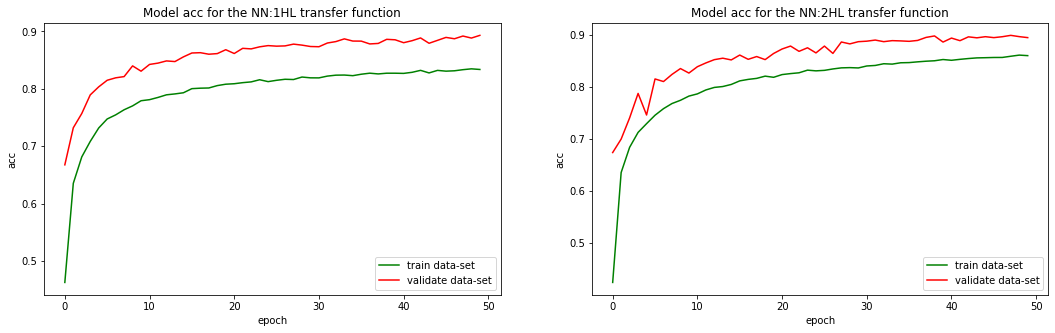

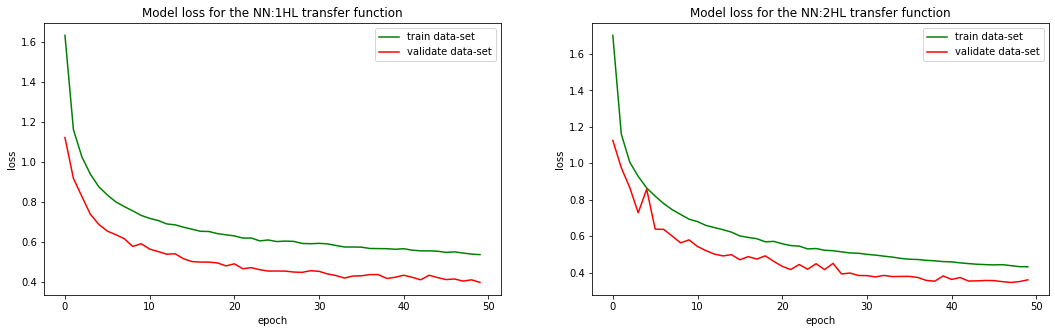

In [100]:
def plot_model_history(ax, history, train_metric, val_metric, actv_func ):
  ax.plot(history[train_metric], 'green',label='train data-set')
  ax.plot(history[val_metric], 'red',label='validate data-set')
  ax.set_title('Model {} for the {} transfer function'.format(train_metric,actv_func))
  ax.set_ylabel(train_metric)
  ax.set_xlabel('epoch')
  ax.legend()


fig, ax = plt.subplots(1, 2, figsize=(18,5))
plot_model_history(ax[0], m1_his.history, 'acc', 'val_acc', 'NN:1HL')
plot_model_history(ax[1], m2_his.history, 'acc', 'val_acc', 'NN:2HL')

fig, ax = plt.subplots(1, 2, figsize=(18,5))
plot_model_history(ax[0], m1_his.history, 'loss', 'val_loss', 'NN:1HL')
plot_model_history(ax[1], m2_his.history, 'loss', 'val_loss', 'NN:2HL')

plt.show()

#### Inferences:
    For the models build model1 & model2 the difference is 
    Model_1: simple and has 1 hidden layer
    Model_2 : Has 2 Hidden layer

and it can infered that model_2 accuracy is better  

#### Build the KNN model for the given dataset

In [101]:
Knn_x_train.shape

(42000, 1024)

In [102]:
np.size(Knn_x_train)

43008000

In [0]:
knn_m1 =  KNeighborsClassifier()

In [104]:
knn_m1.fit(Knn_x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [106]:
knn_m1.score(knn_x_test,y_test)

0.32416666666666666

In [0]:
knn_y_predict = knn_m1.predict(knn_x_test)

In [0]:
#x_val_train1, x_val_train2, 

In [0]:
"""
param_grid = { 'n_neighbors':[5, 11, 15], 'metric':('minkowski', 'manhattan', 'mahalanobis'), 'weights': ('uniform', 'distance') }
kcv = GridSearchCV(knn_m1, param_grid=param_grid, cv=3 )
kcv.fit(knn_x_val,y_val)
print('\nGridSearch Parameter setting that gave the best results on the hold out data\n\t', kcv.best_params_)
print('\nMean cross-validated score of the best_estimator\n\t',kcv.best_score_)
""" 
   

In [0]:
 #print('\nTest score\n\t',kcv.score(knn_x_test,y_test))

### Observation:
    
* From the above it can be understood that KNN accuracy is 37% which is quite lower than the basic Neural Network model.

* Here though the images are not preproceed, the basic NN models gives accuracy 65%.

* Preprocessing the images may improve the accuracy of NN model (as in the process of understanding the preprocessing technique did not not apply it)



###### Note:
    As session got disconnected while running the above GridsearchCV for KNN and as further restarting the session results in longer time of execution for understanding the hypermaters for Neural Network. Hence, could not get the classification metrics and better Knn hyperparameter. 
           
    As of now submitting the assignemnt. Further will execute and understand the behavior.   


### EOF